# Imports

In [1]:
import itertools
import pandas as pd
import random
import plotnine.options
from plotnine import *
from pprint import pprint as pp, pformat
plotnine.options.figure_size = (7, 5)

# Preâmbulo

## Tipos

In [2]:
horas = int
tarefa = int
periodo = (horas, horas)
cromossoma = list[tarefa]
populacaoT = list[cromossoma]

class Maquina:
  def __init__(self, numero: int, n_tarefas: int):
    self.numero = numero
    self.n_tarefas = n_tarefas

  def __repr__(self):
    return f'M{self.numero}'

  def __hash__(self):
    return self.numero

## Valores

In [3]:
Tarefas: dict[tarefa, horas] = {
  t + 1: h for t, h in enumerate([38, 33, 36, 20, 32, 29, 46, 38, 34, 40])
}
restricao_val = acabarAntes = 24 * (5 - 1)
restricao: dict[tarefa, horas] = {  # tempo minimo para a compleção das tarefa
  3: restricao_val,
  4: restricao_val,
  5: restricao_val,
}
maquinas = [Maquina(1, 4), Maquina(2, 3), Maquina(3, 3)]
Tarefas

{1: 38, 2: 33, 3: 36, 4: 20, 5: 32, 6: 29, 7: 46, 8: 38, 9: 34, 10: 40}

## Funções

In [4]:

def log(message, level: int = 1):
  if level == 0: return
  print('    ' * (level - 1) + message)

def pretty_log(message, level: int = 1):
  if level == 0: return
  log(pformat(message), level)

def first(iterable, func, default=None):
  # get first element that satisfies func
  return next(filter(func, iterable), default)


def first_ind(iterable, func, default=None):
  # get index of first element that satisfies func
  return next((i for i, x in enumerate(iterable) if func(x)), default)


set_seed = random.seed

def get_time_of_tarefa(t: tarefa) -> horas:
  return Tarefas[t]

def cromo_to_maqs(cromo: cromossoma) -> dict[Maquina, list[tarefa]]:
  # convert chromosome to machine dictionary
  ret = {m: [] for m in maquinas}
  cut = 0
  for maq, l in ret.items():
    l.extend(cromo[cut:cut + maq.n_tarefas])
    cut += maq.n_tarefas
  return ret

def maqs_to_horario(maqs: dict[Maquina, list[tarefa]]) -> dict[Maquina, list[periodo]]:
  # horario sao as horas acomuladas
  ret = {m: [] for m in maquinas}
  for maq, l in maqs.items():
    ret[maq].append((0, get_time_of_tarefa(l[0])))
    for t in l[1:]:
      ret[maq].append((ret[maq][-1][1], ret[maq][-1][1] + get_time_of_tarefa(t)))
  return ret

def cromo_to_horario(crom: cromossoma) -> dict[tarefa, periodo]:
  maqs: dict[Maquina, list[tarefa]] = cromo_to_maqs(crom)
  horario: dict[Maquina, list[periodo]] = maqs_to_horario(maqs)
  ret = {}
  for m, l in horario.items():
    tarefa_periodo: tuple[tarefa, periodo] = zip(maqs[m], l)
    for t, p in tarefa_periodo:
      ret[t] = p
  return ret

def cromo_respeita_restricao(cromo: cromossoma) -> bool:
  horario: dict[tarefa, periodo] = cromo_to_horario(cromo)
  for t, p in horario.items():
    if t in restricao and p[1] > restricao[t]:
      return False
  return True

def get_tempo_total(cromo: cromossoma) -> horas:
  # tempo máximo de todas as máquinas
  return max([p[1] for t, p in cromo_to_horario(cromo).items()])

def cromos_to_df(*cromos: cromossoma) -> pd.DataFrame:
  # hardcoded, supposed to be:
  # M1: tarefas do M1,
  # M2: tarefas do M2,
  # M3: tarefas do M3,
  # Tempo de execução das Tarefas: tempo máximo de todas as máquinas
  # respeita restricao?: se o horario das tarefas com restricoes acaba antes do valor da restricao
  # respeita unique?: se o cromo nao tem tarefas repetidas
  return pd.DataFrame({
    "M1": [" -> ".join([f"T{i}" for i in c[:4]]) for c in cromos],
    "M2": [" -> ".join([f"T{i}" for i in c[4:7]]) for c in cromos],
    "M3": [" -> ".join([f"T{i}" for i in c[7:]]) for c in cromos],
    "Tempo de execução das Tarefas": [get_tempo_total(c) for c in cromos],
    "respeita restricao?": [cromo_respeita_restricao(c) for c in cromos],
    "respeita unique?": [len(c) == len(set(c)) for c in cromos],
  })

def plot_cromo(cromo: cromossoma):
  maqs = cromo_to_maqs(cromo)
  horario = maqs_to_horario(maqs)
  max_tempo = get_tempo_total(cromo)
  df = pd.DataFrame({
    'maquina': [i for m in maqs for i in [m.numero] * len(maqs[m])],
    'tarefa': [t for m in maqs for t in maqs[m]],
    "tarefaLabel": [f"T{t}" for m in maqs for t in maqs[m]],
    "comeca": [i[0] for m in horario for i in horario[m]],
    "acaba": [i[1] for m in horario for i in horario[m]],
  })
  # noinspection PyTypeChecker,DuplicatedCode
  return ggplot(df, aes(y="maquina")) + geom_point(aes(x="comeca", color="factor(comeca)"), size=5) + \
    geom_path(aes(x="acaba", group="maquina", color="factor(acaba)")) + \
    geom_path(aes(x="comeca", group="maquina", color="factor(comeca)")) + \
    geom_vline(xintercept=max_tempo, linetype="dashed") + \
    geom_text(aes(x="comeca", label="tarefaLabel"), size=10, nudge_x=0.1, nudge_y=0.1) + \
 \
    scale_x_continuous(breaks=[0, 24, 48, 72, 96, max_tempo]) + \
    scale_y_continuous(breaks=[1, 2, 3]) + \
    scale_color_discrete(guide=False) + \
    coord_fixed(xlim=(-0.5, 144)) + \
    labs(x="horas", y="maquina") + \
    theme_classic() + \
    theme(aspect_ratio=0.7)

In [5]:
# exemplo
primeiro = [1,2,3,4,5,6,7,8,9,10]
cromos_to_df(primeiro)

,M1,M2,M3,Tempo de execução das Tarefas,respeita restricao?,respeita unique?
0,T1 -> T2 -> T3 -> T4,T5 -> T6 -> T7,T8 -> T9 -> T10,127,False,True


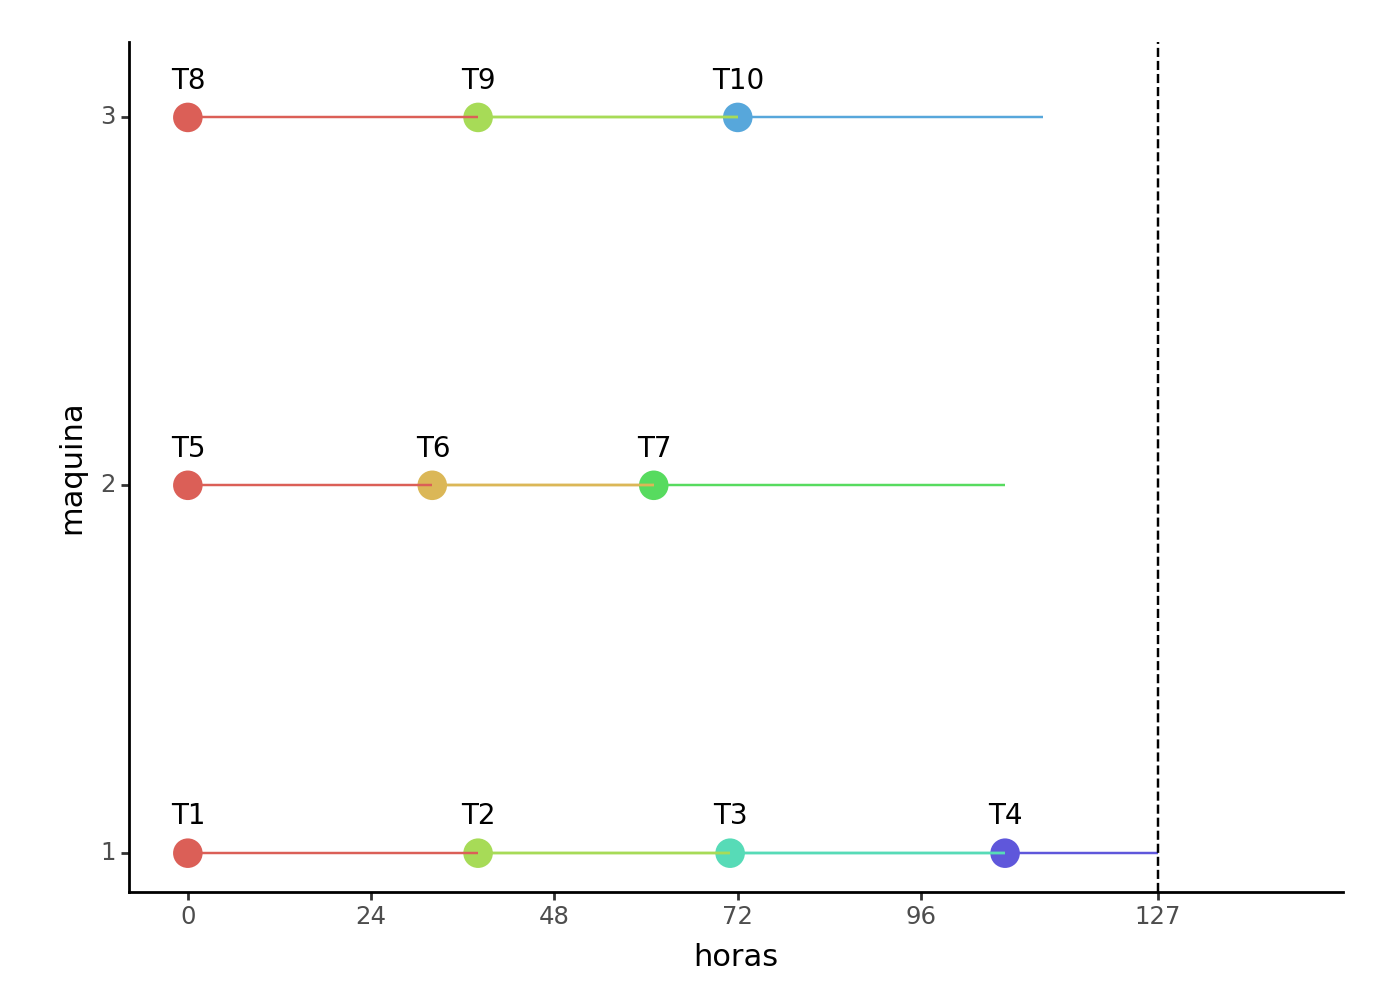

<Figure Size: (700 x 500)>

In [6]:
plot_cromo(primeiro)

# Alínea a) 
**Descreva, por palavras, uma solução admissível para o problema da Química_PT**

* Todas as tarefas têm de ser processadas, independentemente da ordem; 

* Cada tarefa só pode ser processadas uma (1) vez; 

* As tarefas $T_3$, $T_4$ e $T_5$ têm de ser realizadas antes do dia 5 de junho, às 08:00. 

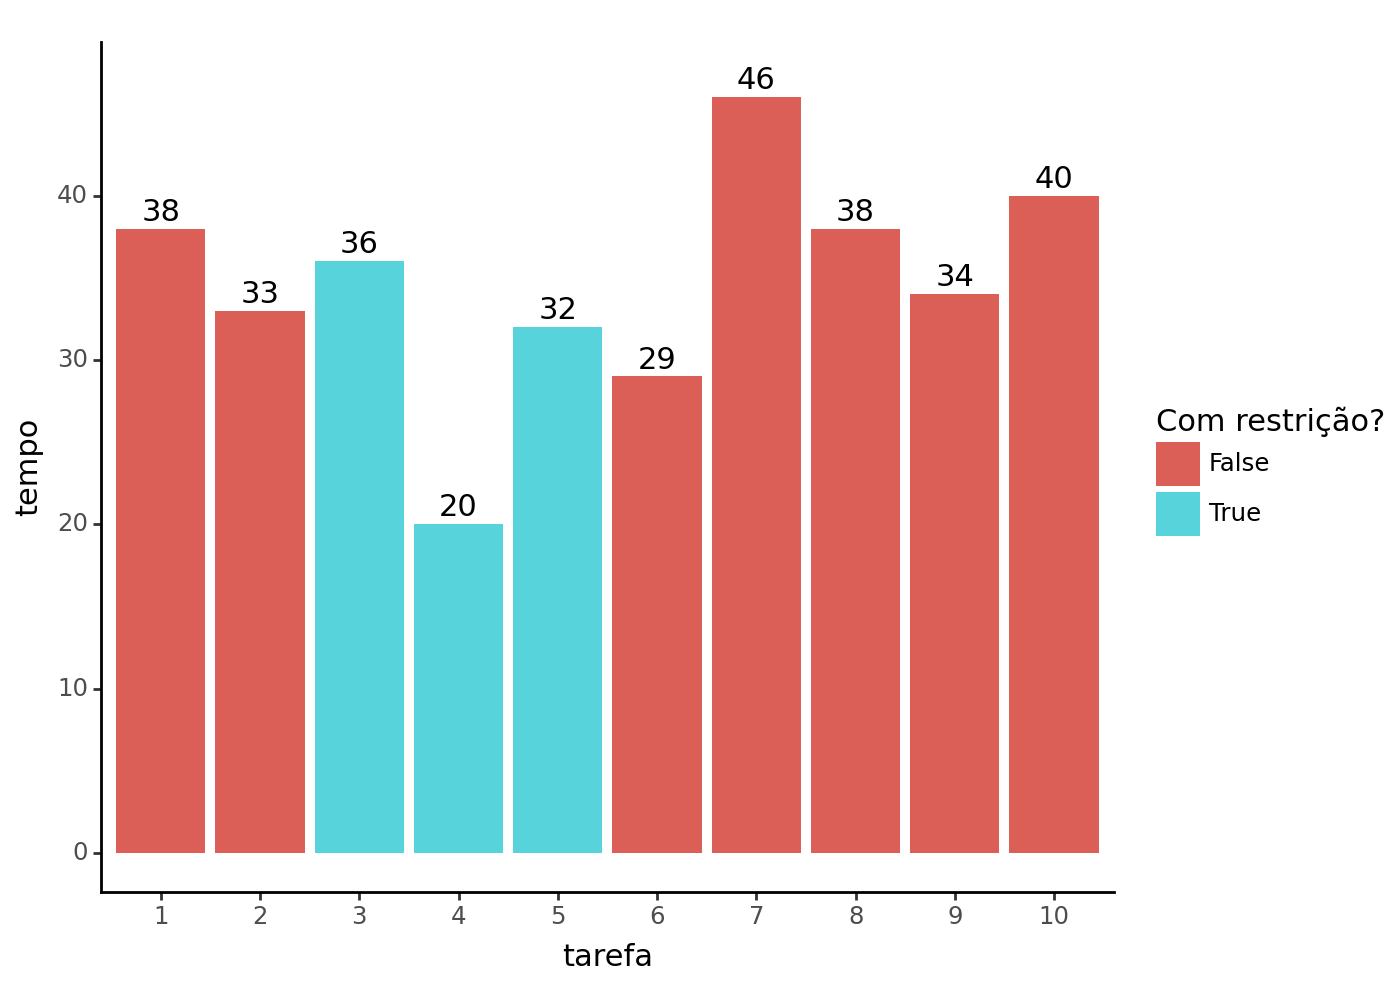

<Figure Size: (700 x 500)>

In [7]:
def plot_tarefas():
  # bar plot com as tarefas e o tempo delas
  df = pd.DataFrame({
    "tarefa": [t for t in Tarefas],
    "tempo": [get_time_of_tarefa(t) for t in Tarefas],
    "prioridade": [t in restricao for t in Tarefas]
  })
  # noinspection PyTypeChecker,DuplicatedCode
  return ggplot(df, aes(x="factor(tarefa)", y="tempo")) + \
    geom_bar(aes(fill="factor(prioridade)"), stat="identity") + \
    geom_text(aes(label="tempo"), nudge_y=1) + \
    scale_fill_discrete(name="Com restrição?") + \
    labs(x="tarefa", y="tempo") + \
    theme_classic()

plot_tarefas()

# Alínea b) 
**Desenvolva uma heurística para determinar uma sequência de processamento das tarefas em cada máquina que respeite a data de conclusão acordada para as tarefas T3, T4 e T5. Com base na heurística desenvolvida, apresente uma solução admissível para o problema da Química_PT.** 

1.Iremos atribuir as 3 tarefas críticas (T3, T4, T5), a cada uma das máquinas, a fim de se conseguir realizar o prazo o mais rápido possivel

  1.1 Vamos dar a mais rápida destas à máquina com mais tarefas (M1), pois esta precisa de fazer 4 tarefas

2.De seguida, será colocado a tarefa mais rápida na máquina com mais tarefas (M1), pois esta precisa de fazer 4 tarefas

3.Por fim, as tarefas restantes serão distribuidas de forma a dar um equilibrio entre elas

  3.1 Para isso, iremos dar as duas mais pequenas seguintes à M1

  3.2 E por a mais pequena e maior das restantes na M2

  3.3 Por fim, as 2 tarefas restantes irão para a M3

In [8]:
def tarefas_as_list() -> list[int]:
  return list(Tarefas.keys())

def get_maquina(index: int) -> Maquina:
  return maquinas[index - 1]

def heuristica() -> cromossoma:
  ret = [0] * len(Tarefas)
  tarefas = tarefas_as_list()
  M1 = get_maquina(1)
  M2 = get_maquina(2)
  M3 = get_maquina(3)
  M1_ind = 0
  M2_ind = M1_ind + M1.n_tarefas
  M3_ind = M2_ind + M2.n_tarefas
  # 1 - atribuir as 3 tarefas criticas às 3 máquinas, M1 recebendo a mais pequena sendo que tem 4
  criticas = list(restricao.keys())
  criticas.sort(key=lambda t: get_time_of_tarefa(t), reverse=False)
  ret[M1_ind], ret[M2_ind], ret[M3_ind] = criticas
  [tarefas.remove(c) for c in criticas]
  # 2 - como a M1 tem 4 tarefas, atribuir as 3 tarefas mais pequenas à M1
  tarefas.sort(key=lambda t: get_time_of_tarefa(t), reverse=False)
  ret[M1_ind + 1:M1_ind + 4] = tarefas[:3]
  # 3 - dividir as restantes tarefas pelas máquinas de forma equilibrada
  # ou seja, M2 vai ter as tarefas mais pequena e maior (das restantes) e M3 vai ter as tarefas do meio
  ret[M2_ind + 1], ret[M3_ind + 1], ret[M3_ind + 2], ret[M2_ind + 2] = tarefas[3:]
  return ret
heur_resultado = heuristica()
cromos_to_df(heur_resultado)

,M1,M2,M3,Tempo de execução das Tarefas,respeita restricao?,respeita unique?
0,T4 -> T6 -> T2 -> T9,T5 -> T1 -> T7,T3 -> T8 -> T10,116,True,True


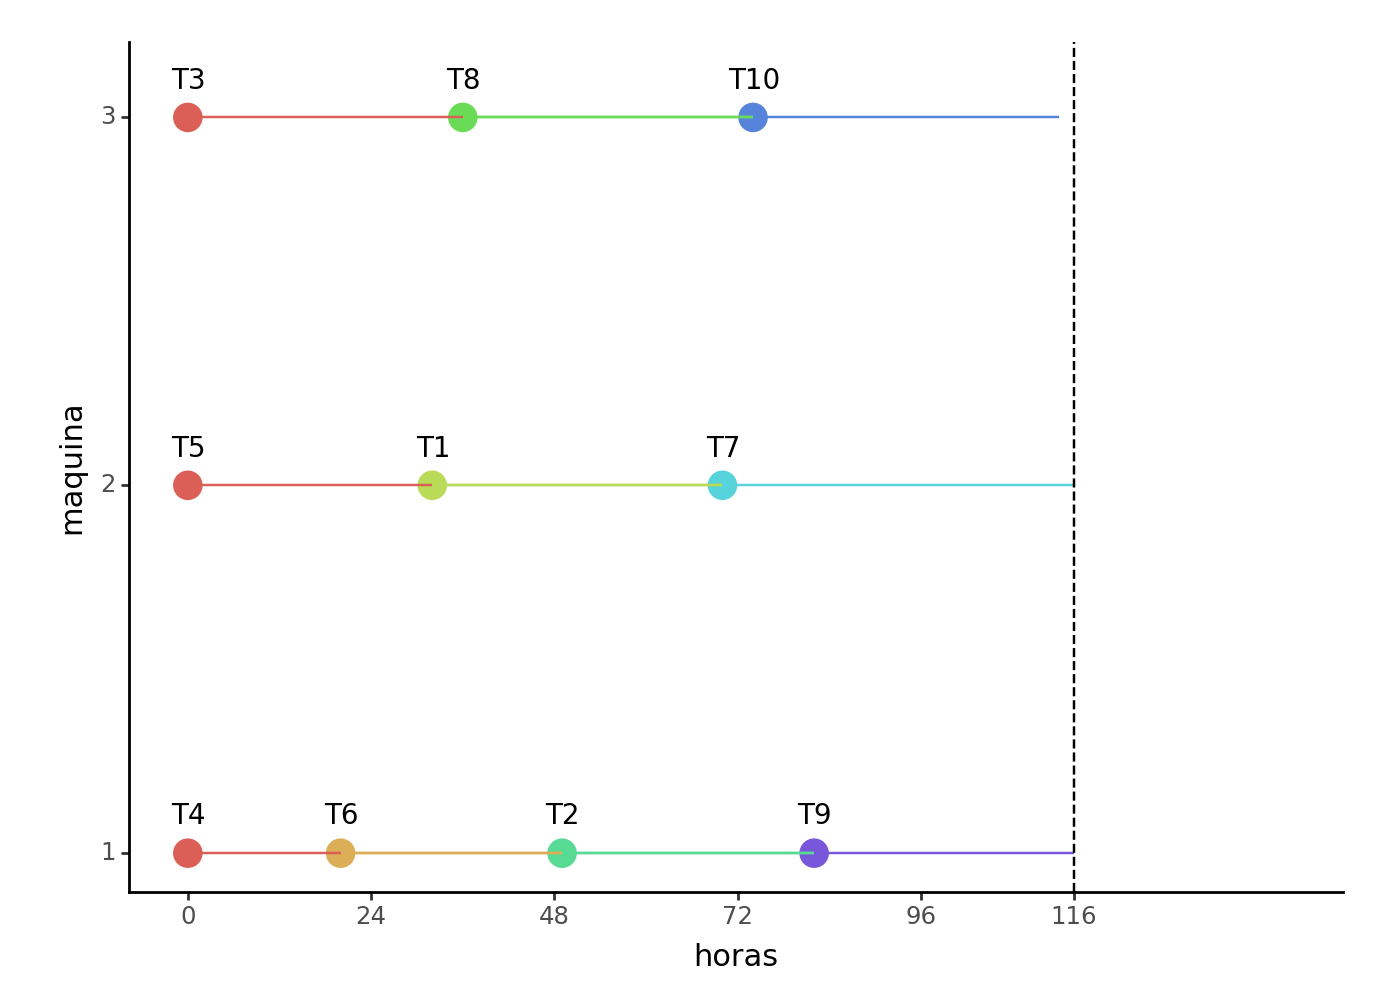

<Figure Size: (700 x 500)>

In [9]:
plot_cromo(heur_resultado)

É possível visualizar que a restrição foi respeitada

# Alínea c) 
**Defina um cromossoma que permita codificar uma sequência de processamento das tarefas em cada máquina.**

In [10]:
heur_resultado

[4, 6, 2, 9, 5, 1, 7, 3, 8, 10]

Nota:
- As 4 primeiras tarefas correspondem à máquina 1
- Da 5 à 7 tarefas correspondem à máquina 2
- As restantes tarefas correspondem à máquina 3

O cromossoma está representado por permutação

# Alínea d) 
**Tendo em conta a codificação que sugeriu em c), proponha um operador de crossover e exemplifique-o no contexto do problema da Química_PT**

**Operador de crossover**

In [11]:
# ERO
def crossover(pai: list[int], mae: list[int], log_level=0, seed=None) -> list[int]:
  if seed is not None: set_seed(seed)
  # selecionar aleatoriamente uma ligacao entre 2 genes, entre os pais, e adicionar a um novo filho
  filho = []
  nao_escolhidos = set(pai)

  # 1º escolher um ponto de partida aleatorio
  ponto_partida = escolhido = random.choice([pai[0], mae[0]])
  # 2º fazer as matrizes de adjacencia (incluindo os ultimos)
  pai_adj = {pai[i]: {pai[i - 1], pai[(i + 1) % len(pai)]} for i in range(len(pai))}
  mae_adj = {mae[i]: {mae[i - 1], mae[(i + 1) % len(mae)]} for i in range(len(mae))}
  # 3º fazer uniao das matrizes de adjacencia
  adj = {i: pai_adj[i] | mae_adj[i] for i in pai_adj}
  log("Adjacencias:", log_level)
  pretty_log(adj, log_level)
  # 4º fazer o filho
  while len(nao_escolhidos) > 1:
    log(f"Não escolhidos:{nao_escolhidos}", log_level)
    log(f"Filho:{filho}", log_level)
    log(f"Escolhido:{escolhido}", log_level)
    # adicionar o escolhido ao filho
    filho.append(escolhido)
    nao_escolhidos.remove(escolhido)

    # conseguir as escolhas possiveis
    escolhas = adj[escolhido] & nao_escolhidos
    if len(escolhas) == 0:
      # se nao houver escolhas, escolher um aleatorio entre os nao escolhidos
      escolhido = random.choice(list(nao_escolhidos))
    else:
      escolhido = random.choice(list(escolhas))
  # adicionar o filho que falta
  filho.append(nao_escolhidos.pop())
  return filho

cruzamento = crossover
# exemplo
filho1 = cruzamento(heur_resultado, primeiro, seed=1, log_level=1)
filho1

Adjacencias:
{1: {10, 2, 5, 7},
 2: {9, 3, 6, 1},
 3: {8, 2, 4, 7},
 4: {10, 3, 5, 6},
 5: {9, 4, 1, 6},
 6: {2, 4, 5, 7},
 7: {8, 1, 3, 6},
 8: {9, 10, 3, 7},
 9: {8, 2, 10, 5},
 10: {8, 9, 4, 1}}
Não escolhidos:{1, 2, 3, 4, 5, 6, 7, 8, 9, 10}
Filho:[]
Escolhido:4
Não escolhidos:{1, 2, 3, 5, 6, 7, 8, 9, 10}
Filho:[4]
Escolhido:10
Não escolhidos:{1, 2, 3, 5, 6, 7, 8, 9}
Filho:[4, 10]
Escolhido:9
Não escolhidos:{1, 2, 3, 5, 6, 7, 8}
Filho:[4, 10, 9]
Escolhido:8
Não escolhidos:{1, 2, 3, 5, 6, 7}
Filho:[4, 10, 9, 8]
Escolhido:7
Não escolhidos:{1, 2, 3, 5, 6}
Filho:[4, 10, 9, 8, 7]
Escolhido:3
Não escolhidos:{1, 2, 5, 6}
Filho:[4, 10, 9, 8, 7, 3]
Escolhido:2
Não escolhidos:{1, 5, 6}
Filho:[4, 10, 9, 8, 7, 3, 2]
Escolhido:6
Não escolhidos:{1, 5}
Filho:[4, 10, 9, 8, 7, 3, 2, 6]
Escolhido:5


[4, 10, 9, 8, 7, 3, 2, 6, 5, 1]

In [12]:
cromos_to_df(primeiro, heur_resultado, filho1)

,M1,M2,M3,Tempo de execução das Tarefas,respeita restricao?,respeita unique?
0,T1 -> T2 -> T3 -> T4,T5 -> T6 -> T7,T8 -> T9 -> T10,127,False,True
1,T4 -> T6 -> T2 -> T9,T5 -> T1 -> T7,T3 -> T8 -> T10,116,True,True
2,T4 -> T10 -> T9 -> T8,T7 -> T3 -> T2,T6 -> T5 -> T1,132,True,True


# Alínea e) 
**Tendo em conta a codificação que sugeriu em c), proponha um operador de mutação e exemplifique-o no contexto do problema da Química_PT.** 

**Operador de Mutação**

### Mutação por troca

In [13]:
def mutacao(crom: cromossoma, prob=.1, seed=None):
  if seed is not None: set_seed(seed)
  crom = crom.copy()
  # Verificar se a mutação será aplicada com base na probabilidade
  if random.random() < prob:
    # Selecionar aleatoriamente duas posições diferentes no cromossomo
    ind1 = random.randint(0, len(crom) - 1)
    ind2 = random.randint(0, len(crom) - 1)

    # Realizar a troca entre as duas posições
    crom[ind1], crom[ind2] = crom[ind2], crom[ind1]
  return crom
filho_mut = mutacao(filho1, prob=1, seed=1)
filho_mut

[4, 7, 9, 8, 10, 3, 2, 6, 5, 1]

In [14]:
cromos_to_df(filho1, filho_mut)

,M1,M2,M3,Tempo de execução das Tarefas,respeita restricao?,respeita unique?
0,T4 -> T10 -> T9 -> T8,T7 -> T3 -> T2,T6 -> T5 -> T1,132,True,True
1,T4 -> T7 -> T9 -> T8,T10 -> T3 -> T2,T6 -> T5 -> T1,138,True,True


# Alínea f) 
**Os operadores propostos em d) e e) garantem a obtenção de soluções admissíveis para o problema da Química_PT? Caso não garantam, justifique que tipos de inadmissibilidades os operadores indicados podem gerar e indique como pode ultrapassar esta situação na implementação do algoritmo genético.**

TODO com texto melhor mas não pq o um cromo não é admissível se não tiver as tais 90 horas naquelas 3 tarefas especias (mas ele garante que tem tarefas unicas (as tarefas não são feitas duas vezes) e que têm todas tamanho 10 (como são unicas significa que todas as tarefas são feitas))

Pra resolver iamos fazer uma penalizacao na funcao de avaliação (q é o tempo_total), mas agr vamos so corrigir no fim

In [15]:
def aptidao(crom: cromossoma) -> float:
  return aptidao_from_tempo_total(get_tempo_total(crom))

def aptidao_from_tempo_total(tempo_total: int) -> float:
  # A aptidao equivale ao inverso do Tempo de execução das Tarefas de execução do cromossomo
  return 1/tempo_total

def cromos_to_df_updated(*cromos: cromossoma) -> pd.DataFrame:
  # same as the one above but sem respeita unique (q é garantido) e com apitdao
  return pd.DataFrame({
    "M1": [" -> ".join([f"T{i}" for i in c[:4]]) for c in cromos],
    "M2": [" -> ".join([f"T{i}" for i in c[4:7]]) for c in cromos],
    "M3": [" -> ".join([f"T{i}" for i in c[7:]]) for c in cromos],
    "Tempo de execução das Tarefas": [get_tempo_total(c) for c in cromos],
    "respeita restricao?": [cromo_respeita_restricao(c) for c in cromos],
    "aptidao": [aptidao(c) for c in cromos]
  })

cromos_to_df_updated(primeiro, heur_resultado, filho1, filho_mut)

,M1,M2,M3,Tempo de execução das Tarefas,respeita restricao?,aptidao
0,T1 -> T2 -> T3 -> T4,T5 -> T6 -> T7,T8 -> T9 -> T10,127,False,0.007874
1,T4 -> T6 -> T2 -> T9,T5 -> T1 -> T7,T3 -> T8 -> T10,116,True,0.008621
2,T4 -> T10 -> T9 -> T8,T7 -> T3 -> T2,T6 -> T5 -> T1,132,True,0.007576
3,T4 -> T7 -> T9 -> T8,T10 -> T3 -> T2,T6 -> T5 -> T1,138,True,0.007246


# Alínea g)

In [16]:
def populacaoInicial(tamanho: int, tamanho_cromo=10, log_level=0, seed = None) -> populacaoT:
  if seed is not None: set_seed(seed)
  populacao = []
  for i in range(tamanho):
    cromo = random.sample(range(1, tamanho_cromo + 1), tamanho_cromo)
    log(f"Cromossoma {i + 1}: {cromo}", log_level+1 if log_level > 0 else 0)
    log(f"Tempos: {[get_time_of_tarefa(i) for i in cromo]}", log_level+1 if log_level > 0 else 0)
    log(f"Tempo de execução das Tarefas: {get_tempo_total(cromo)}", log_level+1 if log_level > 0 else 0)
    populacao.append(cromo)
  return populacao
inicial = populacaoInicial(10, log_level=1, seed=1)

    Cromossoma 1: [3, 2, 5, 1, 4, 6, 8, 10, 9, 7]
    Tempos: [36, 33, 32, 38, 20, 29, 38, 40, 34, 46]
    Tempo de execução das Tarefas: 139
    Cromossoma 2: [2, 8, 1, 7, 4, 6, 9, 3, 10, 5]
    Tempos: [33, 38, 38, 46, 20, 29, 34, 36, 40, 32]
    Tempo de execução das Tarefas: 155
    Cromossoma 3: [4, 2, 6, 1, 7, 8, 5, 9, 10, 3]
    Tempos: [20, 33, 29, 38, 46, 38, 32, 34, 40, 36]
    Tempo de execução das Tarefas: 120
    Cromossoma 4: [1, 9, 4, 7, 8, 6, 2, 5, 10, 3]
    Tempos: [38, 34, 20, 46, 38, 29, 33, 32, 40, 36]
    Tempo de execução das Tarefas: 138
    Cromossoma 5: [8, 5, 1, 4, 9, 10, 2, 3, 7, 6]
    Tempos: [38, 32, 38, 20, 34, 40, 33, 36, 46, 29]
    Tempo de execução das Tarefas: 128
    Cromossoma 6: [6, 9, 7, 5, 10, 2, 3, 8, 4, 1]
    Tempos: [29, 34, 46, 32, 40, 33, 36, 38, 20, 38]
    Tempo de execução das Tarefas: 141
    Cromossoma 7: [10, 1, 8, 2, 6, 4, 5, 3, 9, 7]
    Tempos: [40, 38, 38, 33, 29, 20, 32, 36, 34, 46]
    Tempo de execução das Tarefas: 149
    Cr

In [17]:
class CriteriosDeParagem:
  def __init__(self, iter_max=None, iter_max_sem_melhoria=None, tempo_menos_que=None, ):
    self.iter_max: int = iter_max
    self.no_improv_max: int = iter_max_sem_melhoria
    self.aptidao_minimo: float = aptidao_from_tempo_total(tempo_menos_que) if tempo_menos_que is not None else None


    self.curr_iter = 0
    self.no_improv_iter = 0
    self.current_aptid = 0
    self.has_elite = False

  def shouldStop(self, failsafe = 1000) -> bool:
    # fail safe
    if not self.has_elite: return False
    if self.iter_max is not None and self.curr_iter > failsafe:
      print("WARNING: CriteriosDeParagem.shouldStop() called too many times")
      return True
    return (
      (self.iter_max is not None          and self.curr_iter >= self.iter_max) or
      (self.no_improv_max is not None     and self.no_improv_iter >= self.no_improv_max) or
      (self.aptidao_minimo is not None    and self.current_aptid > self.aptidao_minimo)
    )

  def update(self, latest_elite: int):
    self.curr_iter += 1
    if latest_elite > self.current_aptid:
      self.no_improv_iter = 0
      self.current_aptid = latest_elite
    else:
      self.no_improv_iter += 1
  def firstElite(self, elite: int):
    self.current_aptid = elite
    self.has_elite = True

In [18]:
# selecao proporcional à aptidao
def selecao(populacao: populacaoT) -> tuple[cromossoma, cromossoma]:
  aptidoes = [aptidao(c) for c in populacao]
  return random.choices(populacao, weights=aptidoes, k=2)

In [19]:
def algoritmo_genetico(
    tamanho_populacao: int,
    criterios_de_paragem: CriteriosDeParagem = CriteriosDeParagem(),
    elitismo_tamanho: int = 1,
    log_level: int = 0
) -> tuple[cromossoma, list[populacaoT], list[cromossoma]]:
  should_log = log_level > 0
  ret = []
  # 1. Gerar a população inicial
  if should_log:
    log("|==========================\033[1m População inicial:\033[0m ==========================|", log_level)
  populacao = sorted(populacaoInicial(tamanho_populacao, log_level=log_level+1), key=lambda c: aptidao(c), reverse=True)
  elites = [populacao[i] for i in range(elitismo_tamanho)]
  all_elites = set([tuple(e) for e in elites])
  criterios_de_paragem.firstElite(aptidao(elites[0]))
  if should_log:
    log("\033[1m⚪ Elites:\033[0m", log_level)
    for i, c in enumerate(elites):
      log(f"{i + 1}: {c}", log_level + 1 if log_level > 0 else 0)
      log(f"\033[1m- Tempo de execução das Tarefas: {get_tempo_total(c)}\033[0m", log_level + 2 if log_level > 0 else 0)
      log(f"\033[1m- Aptidão: {aptidao(c)}\033[0m",
          log_level + 2 if log_level > 0 else 0)
  # 2. popular uma nova população
  while not criterios_de_paragem.shouldStop():
    log(f"|==========================\033[1m Geração nº {criterios_de_paragem.curr_iter}\033[0m ==========================|", log_level)
    new_populacao = []
    for _ in range(tamanho_populacao):  # modelo geracional
      # 2.1 seleção dos pais
      pai, mae = selecao(populacao)
      # 2.2 cruzamento
      filho = cruzamento(pai, mae)  # 2.3 mutação
      filho = mutacao(filho)
      # 2.4 adicionar o filho à nova população
      new_populacao.append(filho)
    # 3. elitismo
    # 3.1 obter o(s) menos abto(s)
    new_populacao = sorted(new_populacao, key=lambda c: aptidao(c), reverse=False)
    # 3.2 substituir o(s) menos apto(s) pelo(s) mais apto(s) da população anterior
    for i in range(elitismo_tamanho):
      new_populacao[i] = elites[i]
    new_populacao = sorted(new_populacao, key=lambda c: aptidao(c), reverse=False)
    # 3.3 atualizar os elites se necessário
    [elites.append(new_populacao[-i]) for i in range(1, elitismo_tamanho + 1)]
    log("\033[1m ⚪ Candidatos a Elite: \033[0m", log_level)
    for i, c in enumerate(elites):
      log(f"{i + 1}: {c}", log_level + 1)
      log(f"\033[1m- Tempo de execução das Tarefas: {get_tempo_total(c)}\033[0m", log_level + 2 if log_level > 0 else 0)
      log(f"\033[1m- Aptidão: {aptidao(c)}\033[0m", log_level + 2)
    elites = sorted(elites, key=lambda c: aptidao(c),reverse=True)[:elitismo_tamanho]
    all_elites.update([tuple(e) for e in elites])
    log(" ⚪\033[1m Elite Atualizado⚪\033[0m", log_level)
    for i, c in enumerate(elites):
      log(f"{i + 1}: {c}", log_level + 1)
      log(f"\033[1m- Tempo de execução das Tarefas:\033[0m {get_tempo_total(c)}\033[0m", log_level + 2 if log_level > 0 else 0)
      log(f"\033[1m- Aptidão:\033[0m {aptidao(c)}", log_level + 2)
    # 4. atualizar a população
    ret.append(populacao := new_populacao)
    log("\033[1m⚪População Inteira:\033[0m", log_level)
    for i, c in enumerate(populacao):
      log(f"\033[1m- Cromossoma Nº{i + 1}\033[0m: {c}", log_level + 1)
      log(f"\033[1m- Tempo de execução das Tarefas:\033[0m {get_tempo_total(c)}", log_level + 2 if log_level > 0 else 0)
      log(f"\033[1m- Aptidão:\033[0m {aptidao(c)}", log_level + 2)
    # 5. critérios de paragem
    criterios_de_paragem.update(aptidao(elites[0]))

  return elites[0], ret, list(all_elites) # TODO ver o q ta mal

In [20]:
set_seed(2)
resultado = algoritmo_genetico(
  tamanho_populacao=10,
  criterios_de_paragem=CriteriosDeParagem(iter_max=100, iter_max_sem_melhoria=10, tempo_menos_que=100),
  elitismo_tamanho=1,
  log_level=1
)
print("⚫ \033[1mMelhor solução encontrada:\033[0m", resultado[0])
print("⚫ \033[1mTempo de execução das Tarefas:\033[0m", aptidao(resultado[0])**(-1))

|========================== População inicial: ==========================|
        Cromossoma 1: [1, 2, 9, 3, 8, 7, 5, 4, 10, 6]
        Tempos: [38, 33, 34, 36, 38, 46, 32, 20, 40, 29]
        Tempo de execução das Tarefas: 141
        Cromossoma 2: [10, 3, 7, 6, 4, 5, 9, 8, 2, 1]
        Tempos: [40, 36, 46, 29, 20, 32, 34, 38, 33, 38]
        Tempo de execução das Tarefas: 151
        Cromossoma 3: [1, 10, 6, 4, 3, 7, 5, 8, 9, 2]
        Tempos: [38, 40, 29, 20, 36, 46, 32, 38, 34, 33]
        Tempo de execução das Tarefas: 127
        Cromossoma 4: [4, 10, 1, 2, 3, 7, 5, 6, 9, 8]
        Tempos: [20, 40, 38, 33, 36, 46, 32, 29, 34, 38]
        Tempo de execução das Tarefas: 131
        Cromossoma 5: [8, 7, 6, 9, 5, 3, 10, 2, 1, 4]
        Tempos: [38, 46, 29, 34, 32, 36, 40, 33, 38, 20]
        Tempo de execução das Tarefas: 147
        Cromossoma 6: [8, 9, 4, 10, 3, 7, 6, 5, 2, 1]
        Tempos: [38, 34, 20, 40, 36, 46, 29, 32, 33, 38]
        Tempo de execução das Tarefas: 132
 

Corrigido:  [4, 9, 6, 2, 3, 8, 10, 5, 1, 7]


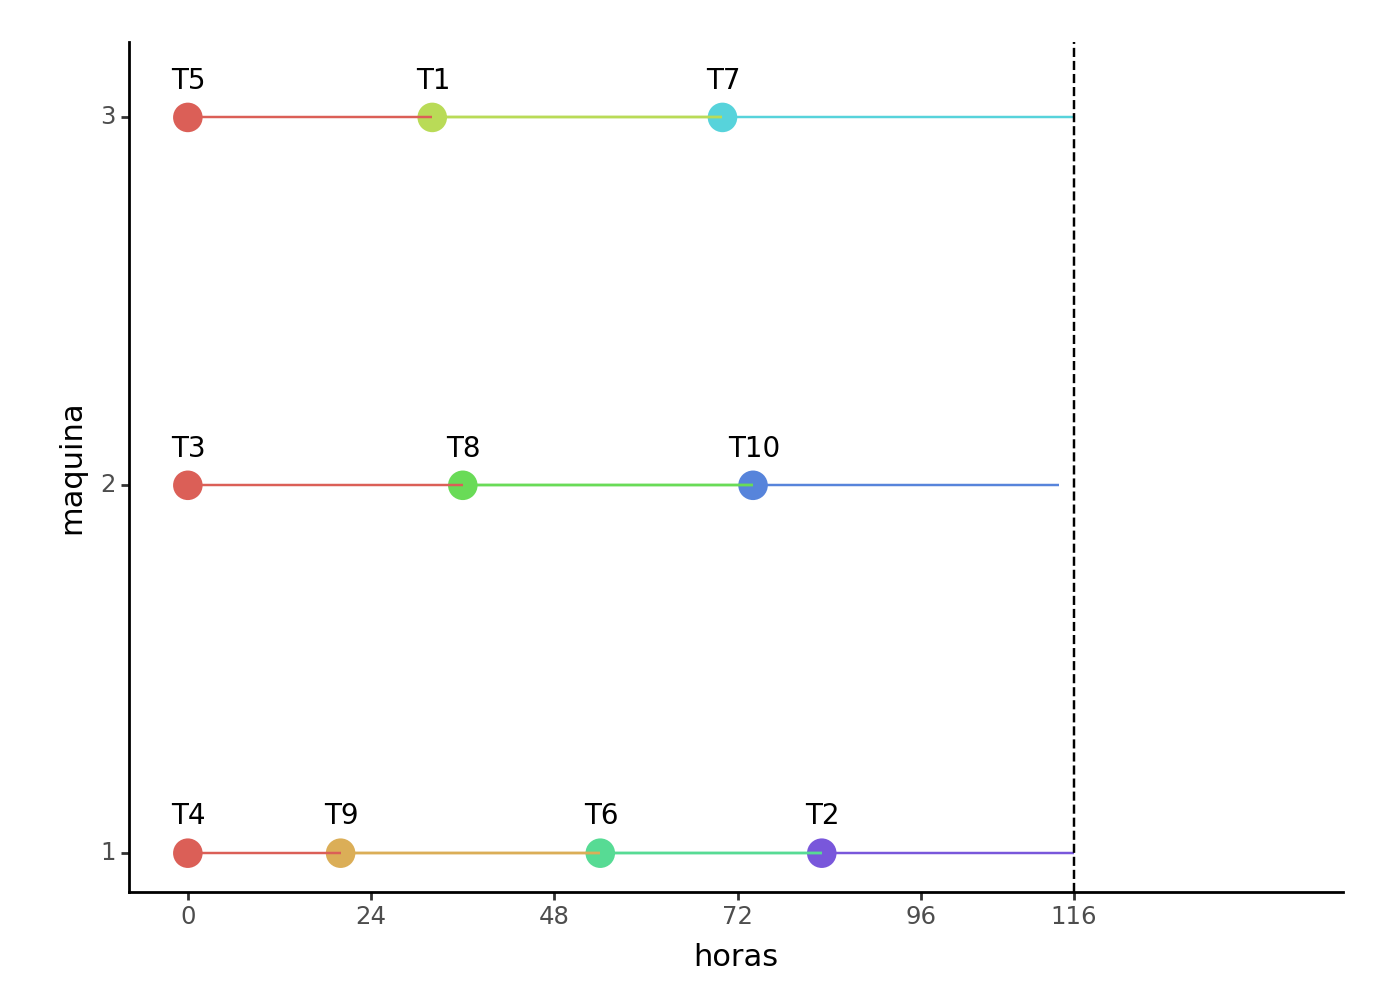

<Figure Size: (700 x 500)>

In [21]:
def maqs_to_cromo(maqs: dict[Maquina, list[tarefa]]) -> cromossoma:
  return [t for m in maqs for t in maqs[m]]

def from_ina_to_adm(cromo: cromossoma) -> cromossoma:
  # puxar pra esquerda todas as tarefas de prioridade, n ve por unicos
  maqs: dict[Maquina, list[tarefa]] = cromo_to_maqs(cromo)
  tarefas_com_restricao = list(restricao.keys())
  for maq in maqs:
    maqs[maq] = sorted(maqs[maq], key=lambda t: t in tarefas_com_restricao, reverse=True)
  return maqs_to_cromo(maqs)

corrigido = from_ina_to_adm(resultado[0])



print("Corrigido: ", corrigido)
plot_cromo(corrigido)

In [22]:
cromos_to_df_updated(resultado[0], corrigido)

,M1,M2,M3,Tempo de execução das Tarefas,respeita restricao?,aptidao
0,T9 -> T4 -> T6 -> T2,T8 -> T10 -> T3,T1 -> T5 -> T7,116,False,0.008621
1,T4 -> T9 -> T6 -> T2,T3 -> T8 -> T10,T5 -> T1 -> T7,116,True,0.008621


In [23]:
# elites
resultado[2]

[(9, 4, 6, 2, 8, 10, 3, 1, 5, 7), (6, 9, 8, 4, 10, 2, 3, 7, 1, 5)]